# A Sentiment Analysis of Yelp Reviews

### 1. Import necessary packages:

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2b. Load the dataset with a sample of 100,000 Yelp reviews, explore the metadata, and add a column "length" that contains the number of words per review:

In [2]:
yelp_data = pd.read_json('C:/Users/user/Downloads/Spring 2023/MACHINE LEARNING/Project/yelp_academic_dataset_review.json', 
                         lines=True, chunksize=100_000)
for chunk in yelp_data:
    yelp_sample_hund_thou = chunk
    result = chunk.to_json(orient="records")
    with open("yelp_sample.json", "w") as f:
        json.dump(result, f)
    break

yelp_sample_hund_thou['length'] = yelp_sample_hund_thou['text'].apply(len)
yelp_sample_hund_thou['stars'] = yelp_sample_hund_thou['stars'].astype(float)

print()
print("Shape of the dataset:", yelp_sample_hund_thou.shape)

print()
print("Dataset Summary:")
yelp_sample_hund_thou.describe(include='all')



Shape of the dataset: (100000, 10)

Dataset Summary:


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,length
count,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000,100000.000000
unique,100000,79345,9973,NaN,NaN,NaN,NaN,99964,99906,NaN
top,KU_O5udG6zpxOg-VcAEodg,_BcWyKQL16ndpBdggh2kNA,GBTPC53ZrG1ZBY3DT8Mbcw,NaN,NaN,NaN,NaN,Service was a little slow to start but improve...,2017-01-15 18:04:45,NaN
freq,1,65,950,NaN,NaN,NaN,NaN,2,2,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005-03-01 17:47:15,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-04 18:22:35,NaN
mean,NaN,NaN,NaN,3.842910,0.898980,0.257180,0.347030,NaN,NaN,548.438330
std,NaN,NaN,NaN,1.354729,2.205186,1.010212,1.066382,NaN,NaN,501.703274
min,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,3.000000
25%,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,NaN,NaN,226.000000


### 3. Plot histograms of review length frenquencies by the star rating:

Text(0.5, 1.0, 'Star Rating Frequency with a RAW Sample of Hundred Thousand')

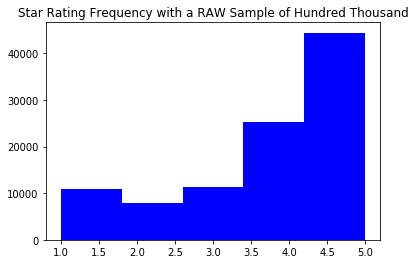

In [3]:
graph_star_freq_raw = plt.hist(yelp_sample_hund_thou['stars'], bins=5, color='blue')
plt.title('Star Rating Frequency with a RAW Sample of Hundred Thousand')

Text(0.5, 1.0, 'Star Rating Frequency with a NORMALIZED Sample of One Million Reviews')

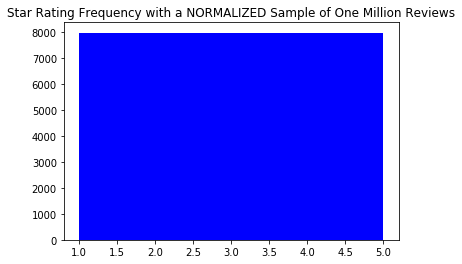

In [5]:
star_counts = yelp_sample_hund_thou['stars'].value_counts()
min_count = star_counts.min()
yelp_sample_equal_hund_thou = yelp_sample_hund_thou.groupby('stars').apply(lambda x: x[:min_count])
count_hund_thou = yelp_sample_equal_hund_thou['stars'].value_counts()


graph_star_freq_normal = plt.hist(yelp_sample_equal_hund_thou['stars'], bins=5, color='blue')
plt.title('Star Rating Frequency with a NORMALIZED Sample of One Million Reviews')

We want to note here that our sample dataset is biased to more positive reviews than negative reviews. As a result, we should proceed with caution when classifying, training, and predicting with this dataset.

### 4.b.i. Classify 100,000 standardized reviews into 1-star (negative), 2-star (negative), 3-star (neutral), 4-star (positive), and 5-star (positive) classes and separate the dataset into X and Y subsets for prediction:

In [45]:
yelp_classify = yelp_sample_equal_hund_thou.loc[:, ['stars', 'text']]

print()
print("Shape of the dataset:", yelp_classify.shape)

x_hund_thou_five = yelp_classify['text']
y_hund_thou_five = yelp_classify['stars']

print()
print("A few X entries")
print(x_hund_thou_five)

print()
print("A few Y entries")
print(y_hund_thou_five)


Shape of the dataset: (39940, 2)

A few X entries
stars       
1.0    5        I am a long term frequent customer of this est...
       47       If you want to pay for everything a la carte t...
       64       The TV shows are $4.99 and they have commercia...
       73       If I could give it a zero, I would. I order a ...
       79       We visited once and were very disappointed in ...
                                      ...                        
5.0    17954    Amidst a long, exciting day of shopping, my fr...
       17958    Great services for a great price! Nail techs a...
       17959    The most amazing place for a guilt free breakf...
       17961    Super cute florist shop. Nice gifts (they offe...
       17964    Omg. The shrimp and grits were amazingly rich ...
Name: text, Length: 39940, dtype: object

A few Y entries
stars       
1.0    5        1.0
       47       1.0
       64       1.0
       73       1.0
       79       1.0
               ... 
5.0    17954    5.0

### 4.b.ii. Classify 100,000 standardized reviews into 1-star (negative) and 5-star (positive) classes and separate the dataset into X and Y subsets for prediction:

In [15]:
yelp_classify = yelp_sample_equal_hund_thou.loc[:, ['stars', 'text']]
data_classes = yelp_classify[(yelp_classify['stars']==1) | 
                           (yelp_classify['stars']==5)]

print()
print("Shape of the dataset:", data_classes.shape)

x_hund_thou_two = data_classes['text']
y_hund_thou_two = data_classes['stars']

print()
print("A few X entries")
print(x_hund_thou_two)

print()
print("A few Y entries")
print(y_hund_thou_two)


Shape of the dataset: (15976, 2)

A few X entries
stars       
1.0    5        I am a long term frequent customer of this est...
       47       If you want to pay for everything a la carte t...
       64       The TV shows are $4.99 and they have commercia...
       73       If I could give it a zero, I would. I order a ...
       79       We visited once and were very disappointed in ...
                                      ...                        
5.0    17954    Amidst a long, exciting day of shopping, my fr...
       17958    Great services for a great price! Nail techs a...
       17959    The most amazing place for a guilt free breakf...
       17961    Super cute florist shop. Nice gifts (they offe...
       17964    Omg. The shrimp and grits were amazingly rich ...
Name: text, Length: 15976, dtype: object

A few Y entries
stars       
1.0    5        1.0
       47       1.0
       64       1.0
       73       1.0
       79       1.0
               ... 
5.0    17954    5.0

### 4.b.iii. Classify 100,000 standardized reviews into 1-star (negative), 3-star (neutral), and 5-star (positive) classes and separate the dataset into X and Y subsets for prediction:

In [51]:
yelp_classify = yelp_sample_equal_hund_thou.loc[:, ['stars', 'text']]
data_classes = yelp_classify[(yelp_classify['stars']==1) | 
                           (yelp_classify['stars']==3) | 
                           (yelp_classify['stars']==5)]

print()
print("Shape of the dataset:", data_classes.shape)

x_hund_thou_three = data_classes['text']
y_hund_thou_three = data_classes['stars']

print()
print("A few X entries")
print(x_hund_thou_three)

print()
print("A few Y entries")
print(y_hund_thou_three)


Shape of the dataset: (23964, 2)

A few X entries
stars       
1.0    5        I am a long term frequent customer of this est...
       47       If you want to pay for everything a la carte t...
       64       The TV shows are $4.99 and they have commercia...
       73       If I could give it a zero, I would. I order a ...
       79       We visited once and were very disappointed in ...
                                      ...                        
5.0    17954    Amidst a long, exciting day of shopping, my fr...
       17958    Great services for a great price! Nail techs a...
       17959    The most amazing place for a guilt free breakf...
       17961    Super cute florist shop. Nice gifts (they offe...
       17964    Omg. The shrimp and grits were amazingly rich ...
Name: text, Length: 23964, dtype: object

A few Y entries
stars       
1.0    5        1.0
       47       1.0
       64       1.0
       73       1.0
       79       1.0
               ... 
5.0    17954    5.0

### 5. Clean the review text by removing stopwords and punctuation:

In [52]:
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### 6.b.i. Convert 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews into vectors:

In [47]:
vocab_hund_thou_five = CountVectorizer(analyzer=process_text).fit(x_hund_thou_five)
r1 = x_hund_thou_five[1]
vocab1 = vocab_hund_thou_five.transform([r1])

print()
print("Number of possible words:", len(vocab_hund_thou_five.vocabulary_))

print()
print("Sample Uncleaned Review:")
print(r1)

print()
print("Vectorized Review:")
print(vocab1)

print()
print("Return word from index 5000:", vocab_hund_thou_five.get_feature_names_out()[5000])
print("Return word from index 20000:", vocab_hund_thou_five.get_feature_names_out()[20000])


Number of possible words: 76896

Sample Uncleaned Review:
5        I am a long term frequent customer of this est...
47       If you want to pay for everything a la carte t...
64       The TV shows are $4.99 and they have commercia...
73       If I could give it a zero, I would. I order a ...
79       We visited once and were very disappointed in ...
                               ...                        
73375    So I've never been to BK, but I'd always heard...
73382    Went to Praline Connection in 2004 and loved i...
73390    There's a reason a nail salon is empty at noon...
73401    TERRIBLE, TERRIBLE SERVICE. Got the wild salmo...
73426    The order was not correct and a member of the ...
Name: text, Length: 7988, dtype: object

Vectorized Review:
  (0, 0)	79
  (0, 85)	1
  (0, 88)	1
  (0, 89)	419
  (0, 90)	493
  (0, 91)	23
  (0, 92)	7
  (0, 106)	1
  (0, 108)	1
  (0, 109)	1
  (0, 120)	1
  (0, 123)	1
  (0, 125)	2
  (0, 162)	1
  (0, 207)	1
  (0, 210)	1
  (0, 215)	1
  (0, 216)	3


### 6.b.ii. Convert 100,000 (1-star and 5-star) reviews into vectors:

In [35]:
vocab_hund_thou_two = CountVectorizer(analyzer=process_text).fit(x_hund_thou_two)
r1 = x_hund_thou_two[1]
vocab1 = vocab_hund_thou_two.transform([r1])

print()
print("Number of possible words:", len(vocab_hund_thou_two.vocabulary_))

print()
print("Sample Uncleaned Review:")
print(r1)

print()
print("Vectorized Review:")
print(vocab1)

print()
print("Return word from index 5000:", vocab_hund_thou_two.get_feature_names_out()[5000])
print("Return word from index 20000:", vocab_hund_thou_two.get_feature_names_out()[20000])


Number of possible words: 45501

Sample Uncleaned Review:
5        I am a long term frequent customer of this est...
47       If you want to pay for everything a la carte t...
64       The TV shows are $4.99 and they have commercia...
73       If I could give it a zero, I would. I order a ...
79       We visited once and were very disappointed in ...
                               ...                        
73375    So I've never been to BK, but I'd always heard...
73382    Went to Praline Connection in 2004 and loved i...
73390    There's a reason a nail salon is empty at noon...
73401    TERRIBLE, TERRIBLE SERVICE. Got the wild salmo...
73426    The order was not correct and a member of the ...
Name: text, Length: 7988, dtype: object

Vectorized Review:
  (0, 0)	79
  (0, 48)	1
  (0, 50)	1
  (0, 51)	419
  (0, 52)	493
  (0, 53)	23
  (0, 54)	7
  (0, 65)	1
  (0, 67)	1
  (0, 68)	1
  (0, 75)	1
  (0, 77)	1
  (0, 78)	2
  (0, 100)	1
  (0, 127)	1
  (0, 129)	1
  (0, 131)	1
  (0, 132)	3
  (0, 

### 6.b.iii. Convert 100,000 (1-star, 3-star, and 5-star) reviews into vectors:

In [53]:
vocab_hund_thou_three = CountVectorizer(analyzer=process_text).fit(x_hund_thou_three)
r1 = x_hund_thou_three[1]
vocab1 = vocab_hund_thou_three.transform([r1])

print()
print("Number of possible words:", len(vocab_hund_thou_three.vocabulary_))

print()
print("Sample Uncleaned Review:")
print(r1)

print()
print("Vectorized Review:")
print(vocab1)

print()
print("Return word from index 5000:", vocab_hund_thou_three.get_feature_names_out()[5000])
print("Return word from index 20000:", vocab_hund_thou_three.get_feature_names_out()[20000])


Number of possible words: 57720

Sample Uncleaned Review:
5        I am a long term frequent customer of this est...
47       If you want to pay for everything a la carte t...
64       The TV shows are $4.99 and they have commercia...
73       If I could give it a zero, I would. I order a ...
79       We visited once and were very disappointed in ...
                               ...                        
73375    So I've never been to BK, but I'd always heard...
73382    Went to Praline Connection in 2004 and loved i...
73390    There's a reason a nail salon is empty at noon...
73401    TERRIBLE, TERRIBLE SERVICE. Got the wild salmo...
73426    The order was not correct and a member of the ...
Name: text, Length: 7988, dtype: object

Vectorized Review:
  (0, 0)	79
  (0, 59)	1
  (0, 61)	1
  (0, 62)	419
  (0, 63)	493
  (0, 64)	23
  (0, 65)	7
  (0, 77)	1
  (0, 79)	1
  (0, 80)	1
  (0, 88)	1
  (0, 90)	1
  (0, 92)	2
  (0, 119)	1
  (0, 151)	1
  (0, 153)	1
  (0, 156)	1
  (0, 157)	3
  (0, 

### 7.b.i. Vectorize all 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews and split processed dataset into training and testing sets:

In [48]:
x_hund_thou_five = vocab_hund_thou_five.transform(x_hund_thou_five)
x_train_hund_thou_five, x_test_hund_thou_five, y_train_hund_thou_five, y_test_hund_thou_five = train_test_split(x_hund_thou_five, y_hund_thou_five, test_size=0.2, random_state=101)

### 7.b.ii. Vectorize all 100,000 (1-star and 5-star) reviews and split processed dataset into training and testing sets:

In [36]:
x_hund_thou_two = vocab_hund_thou_two.transform(x_hund_thou_two)
x_train_hund_thou_two, x_test_hund_thou_two, y_train_hund_thou_two, y_test_hund_thou_two = train_test_split(x_hund_thou_two, y_hund_thou_two, test_size=0.2, random_state=101)

### 7.b.iii. Vectorize all 100,000 (1-star, 3-star, and 5-star) reviews and split processed dataset into training and testing sets:

In [54]:
x_hund_thou_three = vocab_hund_thou_three.transform(x_hund_thou_three)
x_train_hund_thou_three, x_test_hund_thou_three, y_train_hund_thou_three, y_test_hund_thou_three = train_test_split(x_hund_thou_three, y_hund_thou_three, test_size=0.2, random_state=101)

### 8.b.i. Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression:

In [93]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5 = LogisticRegression()
log_hund_5.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5.predict(x_test_hund_thou_five)

print()
print("Accuracy Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))
print("f1_score:", round(f1_score(y_test_hund_thou_five, predlog, average='weighted') * 100, 2))
print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))


Accuracy Score: 52.14
f1_score: 51.96

Classification Report:
              precision    recall  f1-score   support

         1.0       0.65      0.67      0.66      1626
         2.0       0.45      0.44      0.44      1584
         3.0       0.44      0.42      0.43      1650
         4.0       0.45      0.44      0.44      1596
         5.0       0.61      0.65      0.63      1532

    accuracy                           0.52      7988
   macro avg       0.52      0.52      0.52      7988
weighted avg       0.52      0.52      0.52      7988



C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### 8.b.ii. Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression:

In [94]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2 = LogisticRegression()
log_hund_2.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2.predict(x_test_hund_thou_two)

print()
print("Accuracy Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))
print("f1_score:", round(f1_score(y_test_hund_thou_two, predlog, average='binary') * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))


Accuracy Score: 95.53
f1_score: 95.55

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96      1604
         5.0       0.96      0.95      0.95      1592

    accuracy                           0.96      3196
   macro avg       0.96      0.96      0.96      3196
weighted avg       0.96      0.96      0.96      3196



### 8.b.iii. Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression:

In [95]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3 = LogisticRegression()
log_hund_3.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3.predict(x_test_hund_thou_three)

print()
print("Accuracy Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))
print("f1_score:", round(f1_score(y_test_hund_thou_three, predlog, average='weighted') * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))


Accuracy Score: 80.89
f1_score: 80.85

Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.83      0.84      1640
         3.0       0.75      0.74      0.75      1604
         5.0       0.83      0.86      0.84      1549

    accuracy                           0.81      4793
   macro avg       0.81      0.81      0.81      4793
weighted avg       0.81      0.81      0.81      4793



C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### 8.b.i, 8.b.ii,8.b.iii Logistic regressions, L2 penalty as regularization, by default. The following 8.b items are tuning the regularization hyperparameter, changing L2 to L1, and updating lambda λ (C = 1/λ)

### 8.b.i.1 Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=1000


In [60]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5L1 = LogisticRegression(C= 1000, penalty='l1', solver='liblinear')
log_hund_5L1.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5L1.predict(x_test_hund_thou_five)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))


Score: 45.61

Classification Report:
              precision    recall  f1-score   support

         1.0       0.62      0.58      0.60      1626
         2.0       0.39      0.39      0.39      1584
         3.0       0.37      0.36      0.37      1650
         4.0       0.37      0.39      0.38      1596
         5.0       0.54      0.56      0.55      1532

    accuracy                           0.46      7988
   macro avg       0.46      0.46      0.46      7988
weighted avg       0.46      0.46      0.46      7988



### 8.b.i.2 Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=100


Score: 46.82

Classification Report:
              precision    recall  f1-score   support

         1.0       0.62      0.60      0.61      1626
         2.0       0.40      0.40      0.40      1584
         3.0       0.38      0.38      0.38      1650
         4.0       0.39      0.39      0.39      1596
         5.0       0.55      0.57      0.56      1532

    accuracy                           0.47      7988
   macro avg       0.47      0.47      0.47      7988
weighted avg       0.47      0.47      0.47      7988



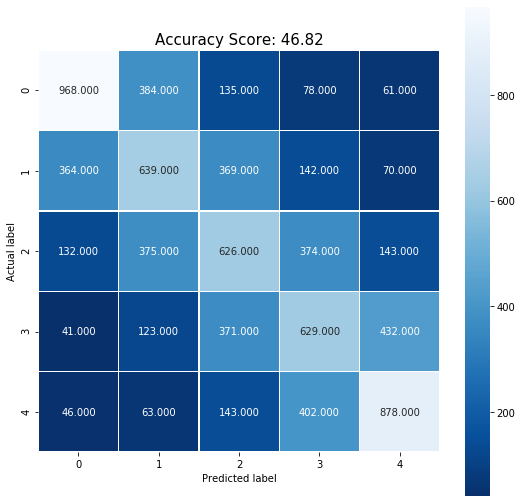

In [78]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5L1 = LogisticRegression(C= 100, penalty='l1', solver='liblinear')
log_hund_5L1.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5L1.predict(x_test_hund_thou_five)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))

cm = confusion_matrix(y_test_hund_thou_five, predlog)
score = round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.i.3 Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=10

In [74]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5L1 = LogisticRegression(C= 10, penalty='l1', solver='liblinear')
log_hund_5L1.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5L1.predict(x_test_hund_thou_five)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))


Score: 48.77

Classification Report:
              precision    recall  f1-score   support

         1.0       0.64      0.64      0.64      1626
         2.0       0.42      0.41      0.41      1584
         3.0       0.41      0.39      0.40      1650
         4.0       0.40      0.40      0.40      1596
         5.0       0.57      0.60      0.58      1532

    accuracy                           0.49      7988
   macro avg       0.49      0.49      0.49      7988
weighted avg       0.49      0.49      0.49      7988



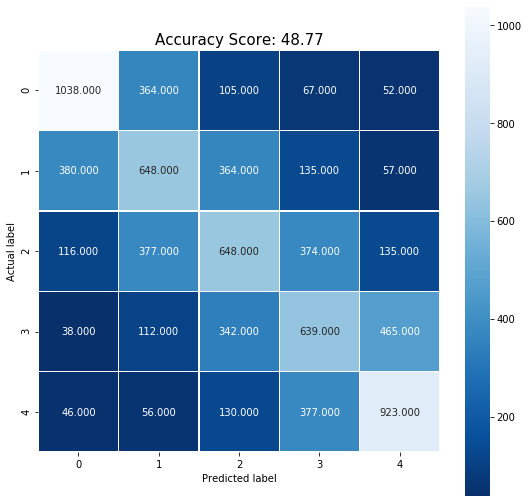

In [75]:
cm = confusion_matrix(y_test_hund_thou_five, predlog)
score = round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.i.4 Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=1


Score: 52.44

Classification Report:
              precision    recall  f1-score   support

         1.0       0.66      0.69      0.67      1626
         2.0       0.46      0.43      0.44      1584
         3.0       0.44      0.41      0.43      1650
         4.0       0.44      0.42      0.43      1596
         5.0       0.60      0.68      0.64      1532

    accuracy                           0.52      7988
   macro avg       0.52      0.53      0.52      7988
weighted avg       0.52      0.52      0.52      7988



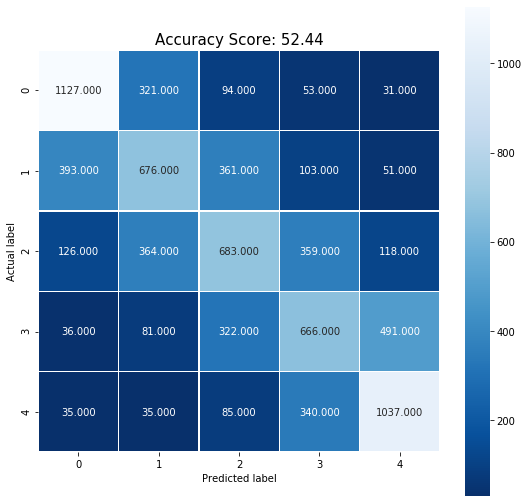

In [87]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5L1 = LogisticRegression(C= 1, penalty='l1', solver='liblinear')
log_hund_5L1.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5L1.predict(x_test_hund_thou_five)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))

cm = confusion_matrix(y_test_hund_thou_five, predlog)
score = round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.i.5 Modeling 100,000 (1-star, 2-star, 3-star, 4-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=0.1


Score: 54.66

Classification Report:
              precision    recall  f1-score   support

         1.0       0.64      0.76      0.69      1626
         2.0       0.50      0.42      0.46      1584
         3.0       0.49      0.40      0.44      1650
         4.0       0.47      0.43      0.45      1596
         5.0       0.58      0.72      0.65      1532

    accuracy                           0.55      7988
   macro avg       0.54      0.55      0.54      7988
weighted avg       0.54      0.55      0.54      7988



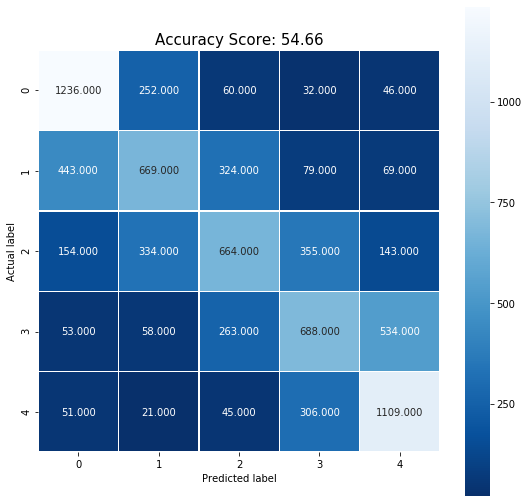

In [88]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_5L1 = LogisticRegression(C= 0.1, penalty='l1', solver='liblinear')
log_hund_5L1.fit(x_train_hund_thou_five, y_train_hund_thou_five)
predlog = log_hund_5L1.predict(x_test_hund_thou_five)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_five, predlog))

cm = confusion_matrix(y_test_hund_thou_five, predlog)
score = round(accuracy_score(y_test_hund_thou_five, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.ii.1 Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression: update regularization: L1, C=1000

In [64]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2L1 = LogisticRegression(C= 1000, penalty='l1', solver='liblinear')
log_hund_2L1.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2L1.predict(x_test_hund_thou_two)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))



Score: 95.65

Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96      1604
         5.0       0.95      0.96      0.96      1592

    accuracy                           0.96      3196
   macro avg       0.96      0.96      0.96      3196
weighted avg       0.96      0.96      0.96      3196



### 8.b.ii.2 Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression: update regularization: L1, C=100

In [65]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2L1 = LogisticRegression(C= 100, penalty='l1', solver='liblinear')
log_hund_2L1.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2L1.predict(x_test_hund_thou_two)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))


Score: 95.18

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95      1604
         5.0       0.95      0.95      0.95      1592

    accuracy                           0.95      3196
   macro avg       0.95      0.95      0.95      3196
weighted avg       0.95      0.95      0.95      3196



### 8.b.ii.3 Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression: update regularization: L1, C=10

In [79]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2L1 = LogisticRegression(C= 10, penalty='l1', solver='liblinear')
log_hund_2L1.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2L1.predict(x_test_hund_thou_two)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))




Score: 94.71

Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      1604
         5.0       0.95      0.94      0.95      1592

    accuracy                           0.95      3196
   macro avg       0.95      0.95      0.95      3196
weighted avg       0.95      0.95      0.95      3196



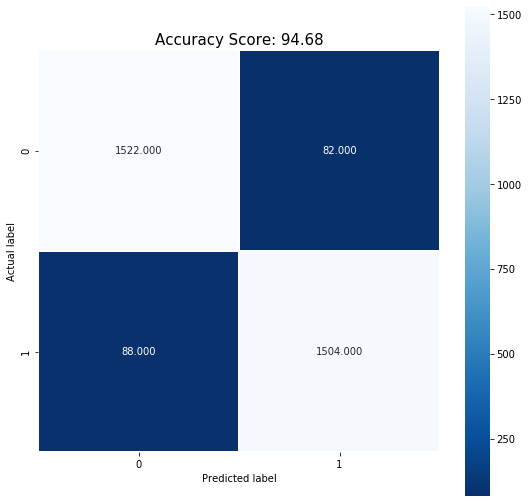

In [73]:
cm = confusion_matrix(y_test_hund_thou_two, predlog)
score = round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.ii.4 Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression: update regularization: L1, C=1


Score: 95.28

Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95      1604
         5.0       0.96      0.95      0.95      1592

    accuracy                           0.95      3196
   macro avg       0.95      0.95      0.95      3196
weighted avg       0.95      0.95      0.95      3196



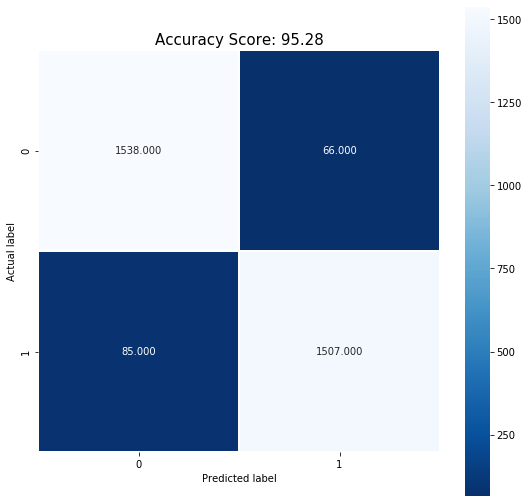

In [76]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2L1 = LogisticRegression(C= 1, penalty='l1', solver='liblinear')
log_hund_2L1.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2L1.predict(x_test_hund_thou_two)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))

cm = confusion_matrix(y_test_hund_thou_two, predlog)
score = round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.ii.5 Modeling 100,000 (1-star and 5-star) reviews with Logistic Regression: update regularization: L1, C=0.1


Score: 93.46

Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      1604
         5.0       0.94      0.92      0.93      1592

    accuracy                           0.93      3196
   macro avg       0.93      0.93      0.93      3196
weighted avg       0.93      0.93      0.93      3196



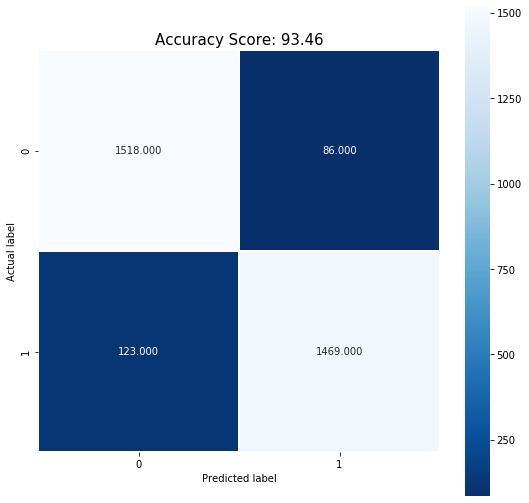

In [77]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_2L1 = LogisticRegression(C= 0.1, penalty='l1', solver='liblinear')
log_hund_2L1.fit(x_train_hund_thou_two, y_train_hund_thou_two)
predlog = log_hund_2L1.predict(x_test_hund_thou_two)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_two, predlog))

cm = confusion_matrix(y_test_hund_thou_two, predlog)
score = round(accuracy_score(y_test_hund_thou_two, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.iii.1 Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=1000¶



Score: 77.86

Classification Report:
              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81      1640
         3.0       0.71      0.70      0.71      1604
         5.0       0.79      0.85      0.82      1549

    accuracy                           0.78      4793
   macro avg       0.78      0.78      0.78      4793
weighted avg       0.78      0.78      0.78      4793



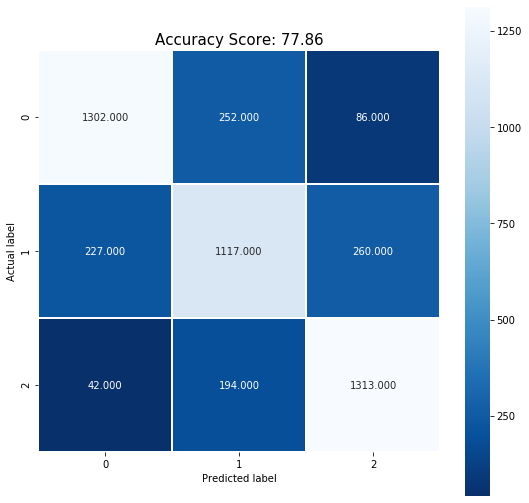

In [82]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3L1 = LogisticRegression(C= 1000, penalty='l1', solver='liblinear')
log_hund_3L1.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3L1.predict(x_test_hund_thou_three)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))

cm = confusion_matrix(y_test_hund_thou_three, predlog)
score = round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.iii.2 Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=100



Score: 78.01

Classification Report:
              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81      1640
         3.0       0.71      0.71      0.71      1604
         5.0       0.80      0.85      0.82      1549

    accuracy                           0.78      4793
   macro avg       0.78      0.78      0.78      4793
weighted avg       0.78      0.78      0.78      4793



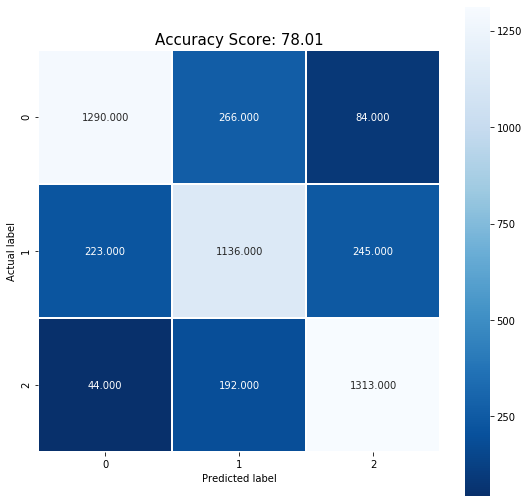

In [83]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3L1 = LogisticRegression(C= 100, penalty='l1', solver='liblinear')
log_hund_3L1.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3L1.predict(x_test_hund_thou_three)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))

cm = confusion_matrix(y_test_hund_thou_three, predlog)
score = round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.iii.3 Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=10



Score: 78.3

Classification Report:
              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81      1640
         3.0       0.72      0.71      0.71      1604
         5.0       0.81      0.85      0.83      1549

    accuracy                           0.78      4793
   macro avg       0.78      0.78      0.78      4793
weighted avg       0.78      0.78      0.78      4793



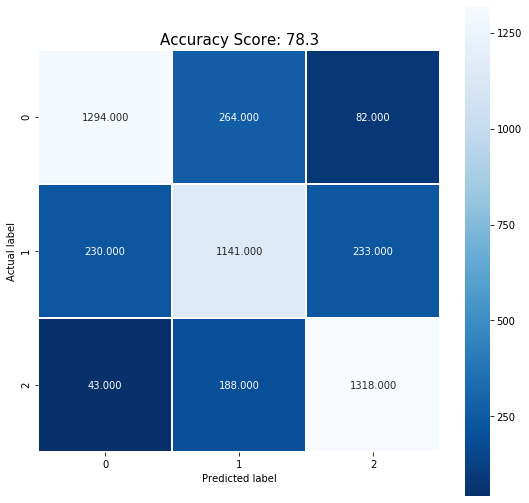

In [84]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3L1 = LogisticRegression(C= 10, penalty='l1', solver='liblinear')
log_hund_3L1.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3L1.predict(x_test_hund_thou_three)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))

cm = confusion_matrix(y_test_hund_thou_three, predlog)
score = round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.iii.4 Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=1



Score: 80.45

Classification Report:
              precision    recall  f1-score   support

         1.0       0.84      0.82      0.83      1640
         3.0       0.75      0.73      0.74      1604
         5.0       0.82      0.86      0.84      1549

    accuracy                           0.80      4793
   macro avg       0.80      0.80      0.80      4793
weighted avg       0.80      0.80      0.80      4793



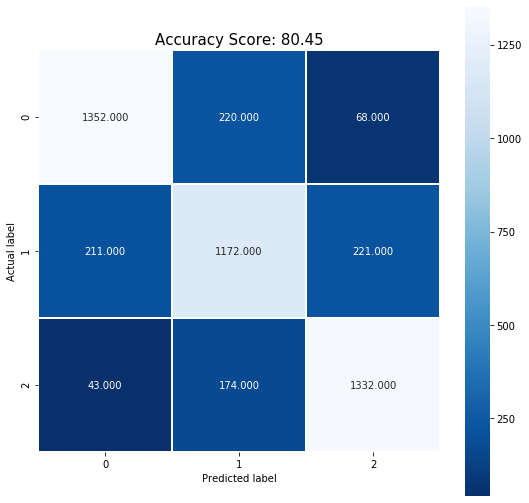

In [85]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3L1 = LogisticRegression(C= 1, penalty='l1', solver='liblinear')
log_hund_3L1.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3L1.predict(x_test_hund_thou_three)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))

cm = confusion_matrix(y_test_hund_thou_three, predlog)
score = round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### 8.b.iii.4 Modeling 100,000 (1-star, 3-star, and 5-star) reviews with Logistic Regression: update regularization: L1, C=0.1



Score: 80.05

Classification Report:
              precision    recall  f1-score   support

         1.0       0.83      0.84      0.83      1640
         3.0       0.77      0.71      0.74      1604
         5.0       0.80      0.86      0.83      1549

    accuracy                           0.80      4793
   macro avg       0.80      0.80      0.80      4793
weighted avg       0.80      0.80      0.80      4793



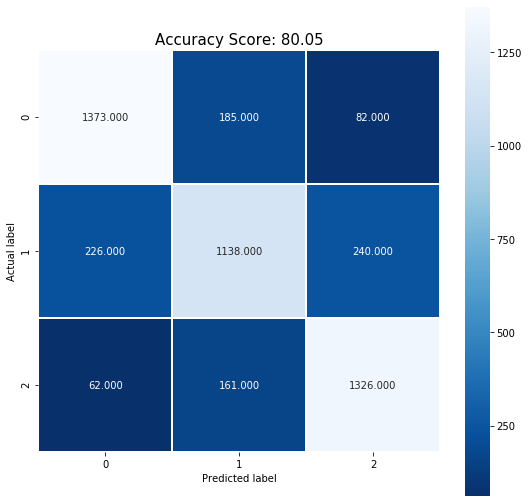

In [86]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_hund_3L1 = LogisticRegression(C= 0.1, penalty='l1', solver='liblinear')
log_hund_3L1.fit(x_train_hund_thou_three, y_train_hund_thou_three)
predlog = log_hund_3L1.predict(x_test_hund_thou_three)

print()
print("Score:", round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2))

print()
print("Classification Report:")
print(classification_report(y_test_hund_thou_three, predlog))

cm = confusion_matrix(y_test_hund_thou_three, predlog)
score = round(accuracy_score(y_test_hund_thou_three, predlog) * 100, 2)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);